# SOMPZ
### The purpose of this notebook is to take a wide, deep and balrog catalogs and create N(z)'s

### 1. Load packages

In [145]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp

n_deep, n_wide = 48, 26
nbins=30
zmin, zmax = 0, 2

z_edges = np.linspace(zmin,zmax,nbins)
zs = .5*np.array([z_edges[i]+z_edges[i+1] for i in range(nbins-1)])

### 2. load functions

In [144]:
#add descriptions to functions!!!

def hist(a):
    return list(np.histogram(a, bins=np.linspace(0,2,nbins), density=False)[0])

def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30

def goldish_cut(df, fluxcols=['FLUX_R', 'FLUX_I', 'FLUX_Z'], fluxerrcols=['FLUX_ERR_R', 'FLUX_ERR_I', 'FLUX_ERR_Z']):
    '''
    will need to be updated once we have all columns used in the actual gold cut
    '''
    # count how many galaxies pass the metacal cuts
    # histogram to compare distributions 2d contour triangle plot
    #print(df)
    flux_r, flux_i, flux_z = (df[fluxcol] for fluxcol in fluxcols)
    flux_err_r, flux_err_i, flux_err_z = (df[fluxerrcol] for fluxerrcol in fluxerrcols)

    # flux_err_r, flux_err_i, flux_err_z = np.array(f['mcal_flux_err_noshear']).T
    mag_r = flux2mag(flux_r)
    mag_i = flux2mag(flux_i)
    mag_z = flux2mag(flux_z)

    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

#     SNR = np.sqrt((flux_i/flux_err_r)**2 + (flux_r/flux_err_r)**2 + (flux_z/flux_err_z)**2) #calculate another way, divide flux/fluxerr

#     #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
#     SNR_Mask = (SNR > 10) & (SNR < 1000)

    Mask = mcal_pz_mask #& SNR_Mask
    return Mask

def deep_cuts(df):
    # Mask flagged regions
    
    deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
    # remove crazy colors, defined as two 
    # consecutive colors (e.g u-g, g-r, r-i, etc) 
    # that have a value smaler than -1
    mags_d = np.zeros((len(df),len(deep_bands_)))
    magerrs_d = np.zeros((len(df),len(deep_bands_)))

    for i,band in enumerate(deep_bands_):
        #print(i,band)
        mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

    colors = np.zeros((len(df),len(deep_bands_)-1))
    for i in range(len(deep_bands_)-1):
        colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

    normal_colors = np.mean(colors > -1, axis=1) == 1
    normal_colors.sum()

    i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
    r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
    z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
    k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)

    return (flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25)&(normal_colors)&((z-k) > 0.5*(r-z))

def foreground_gold(cat):
    MASK = hp.read_map('/project/chihway/dhayaa/DECADE/Gold_Foreground_20230520.fits') == 0
    return MASK[hp.ang2pix(4096, cat['true_ra'], cat['true_dec'], lonlat = True)]

In [ ]:
wide = np.load('/project/chihway/raulteixeira/data/BPZ+SOM_mcal_gold_wide_26x26_ids+cells+fluxes.npz')['arr_0']
wide = pd.DataFrame(wide)

len(wide)
wide['wide_cells']=wide['cells']

In [ ]:
deep_cells = pd.read_csv('/project/chihway/raulteixeira/data/deep_fields_nice_n_z.csv.gz')[['ID', 'cells']]
deep_cells['deep_cells']=deep_cells['cells']
deep = pd.read_csv('/project/chihway/raulteixeira/data/deepfields_with_redshifts.csv.gz')
deepmask = deep_cuts(deep)
deep = deep[deepmask]
deep = deep.merge(deep_cells, on='ID', how='left')

In [146]:
balrog = pd.read_csv('/project/chihway/raulteixeira/data/som_BalrogOfTheDECADE_20231002_26x26_ids+cells+fluxes.csv.gz')#[:int(4.5e6)]
balrog_rest = pd.read_csv('/project/chihway/raulteixeira/data/som_BalrogOfTheDECADE_20231002_26x26_REST.csv.gz')#[:int(4.5e6)]
#balrog = balrog.merge(balrog_rest, on='ID')

balrog['detected']=balrog_rest['detected']
balrog = balrog[foreground_gold(balrog)]

In [22]:
bdf_wide = pd.read_hdf('/project2/chihway/raulteixeira/data/bdf_photometry/dr3_1_1_bdf_metacal_gold.h5', key='df')

wide = wide.merge(bdf_wide, on='COADD_OBJECT_ID')

In [90]:
deep_cells = pd.read_csv('/project/chihway/raulteixeira/data/deep_fields_nice_n_z.csv.gz')[['ID', 'cells']]
deep_cells['deep_cells']=deep_cells['cells']
deep = pd.read_csv('/project/chihway/raulteixeira/data/deepfields_with_redshifts.csv.gz')
deepmask = deep_cuts(deep)
deep = deep[deepmask]
deep = deep.merge(deep_cells, on='ID', how='left')

### Create magnitude columns in deep catalog

In [94]:
bands = ['G', 'R', 'I', 'Z']
for band in bands:

    fluxcol = f'BDF_FLUX_DERED_CALIB_{band}'
    fluxerrcol = f'BDF_FLUX_ERR_DERED_CALIB_{band}'
    
    magcol = f'BDF_MAG_DERED_CALIB_{band}'
    magerrcol = f'BDF_MAG_ERR_DERED_CALIB_{band}'

    deep[magcol]=flux2mag(deep[fluxcol])
    deep[magerrcol]=flux2mag(deep[fluxerrcol])

### contaminant cut

In [147]:
d_arcsec = balrog_rest['d_arcsec']
d_contam_arcsec = balrog_rest['d_contam_arcsec']

balrog['contmask'] = (d_contam_arcsec > 1.5)
balrog_deep = balrog.merge(deep, on='ID', how='left')

### gold(ish) cut

In [149]:
balrog['passes'] = goldish_cut(balrog, fluxcols=[f'mcal_FLUX_{band}' for band in ['r', 'i', 'z']], fluxerrcols=[f'mcal_FLUX_{band}_ERR' for band in ['r', 'i', 'z']])
balrog_deep['passes'] = goldish_cut(balrog_deep, fluxcols=[f'mcal_FLUX_{band}' for band in ['r', 'i', 'z']], fluxerrcols=[f'mcal_FLUX_{band}_ERR' for band in ['r', 'i', 'z']])

unique_ids, counts_true = np.unique(balrog.ID.values, return_counts=True)
unique_ids_detected, counts_detected = np.unique(balrog.ID.values[balrog.passes.values], return_counts=True)

df0 = pd.DataFrame()

df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()

df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left')

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] #p(\hat{c})

balrog = balrog.merge(df_[['ID', 'p_pass']], on='ID')

/home/raulteixeira/.conda/envs/raul/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/raulteixeira/.conda/envs/raul/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/jobs/30549351/ipykernel_140860/4010672856.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0


### Create and marginalize probabilities to obtain Balrog Transfer Matrix

In [150]:
#p(c)
square_len_deep = deep[['BDF_MAG_DERED_CALIB_I', 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
counts_deep = square_len_deep.BDF_MAG_DERED_CALIB_I.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

#p(\hat{c})
#square_p_c_hat = balrog[balrog.detected.values.astype(bool)]\
#[['p_pass', 'wide_cells']].groupby('wide_cells').agg(['mean', 'median', 'std', len])

square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide = square_p_c_hat.COADD_OBJECT_ID.len

balrog['detected_float'] = balrog.detected.astype(float)

square_det = balrog[['detected_float', 'wide_cells']].groupby('wide_cells')\
.agg(['mean', 'median', 'std', len])

#square_wide = wide['wide_cells'].groupby('wide_cells').agg(['mean', 'median', 'std', len])

p_c_hat = ((counts_wide/counts_wide.sum()).values\
           *square_det.detected_float['mean'].values).reshape(n_wide,n_wide)

#p(c,\hat{c})
N_wide, N_deep = 26**2, 48**2
sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values[index],
'wide_cell': balrog_deep.wide_cells.values[index],
'deep_cell': balrog_deep.deep_cells.values[index],
'N_inj':counts_true})

p_cchat = np.zeros((N_wide, N_deep))
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask[index]].astype(int),\
                    InjDF.deep_cell.values[sel_mask[index]].astype(int)), 1.0 /\
          InjDF.N_inj.values[sel_mask[index]])

#p(c)p(\hat{c})
p_c_p_c_hat = (p_c.flatten() * np.repeat(p_c_hat, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

### $p(z|\hat{c}) = \sum_{c} p(z|c) p(c) \dfrac{p(c,\hat{c})}{p(c)p(\hat{c})} p(\hat{c})$

In [151]:
#cell weights
joint_cell_weight = p_c.flatten() * balrog_term * p_c_hat.flatten()[:,None]

#p(z|c)
cell_z = deep[['Z', 'cells']].groupby('cells').agg(func=hist)
p_z_c = np.array([cell_z['Z'][cell] for cell in cell_z['Z'].index])

zero_mask = np.sum(p_z_c, axis=1)==0
rangedeep = np.arange(0, n_deep**2)
nonzero_indices = rangedeep[~zero_mask]

p_z_c = p_z_c[nonzero_indices].astype('float64')
p_z_c /= np.sum(p_z_c, axis=1)[:,None]

#inner sum result of eq. 14 in Myles, Alarcon
p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c)

### $p(z|\hat{b}) = \sum_{\hat{c}\in\hat{b}} p(z|\hat{c})$

In [152]:
Tomo_cells = np.load('/project/chihway/raulteixeira/data/TomoBins_cell_wide_26x26.npz')
p_z_c_hat[Tomo_cells[f'bin0_cells']].sum(axis=0).shape
p_z_c_hat_bins = [np.sum(p_z_c_hat[Tomo_cells[f'bin{i}_cells']], axis=0) for i in range(4)]

In [153]:
[np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * np.linspace(0, 2, nbins)[:-1]) for i in range(4)]

[0.34349441355749133,
 0.5870861866795578,
 0.7549304613254041,
 0.8913306853605467]

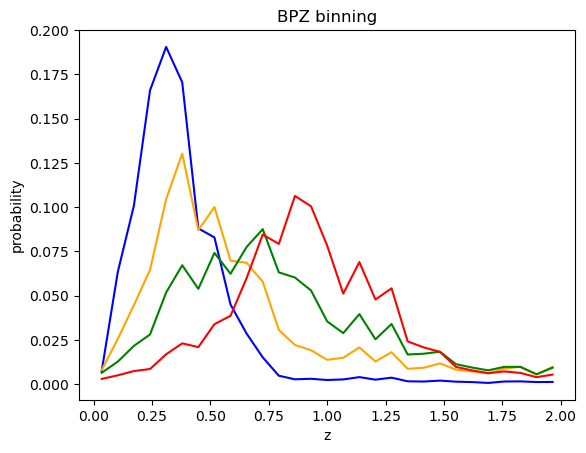

In [154]:
plt.figure()
plt.xlabel('z')
plt.ylabel('probability')
plt.title('BPZ binning')
#plt.xlim(0, 1.5)
#plt.xticks(ticks=np.arange(0,1.5,.1))
colors = ['blue', 'orange', 'green', 'red']
for i in range(4):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i])
plt.show()

In [155]:
#np.savez('/project/chihway/raulteixeira/data/p_z_c_hat_bins_BPZ.npz', np.array(p_z_c_hat_bins))

#np.savetxt('/project/chihway/raulteixeira/data/p_z_c_hat_bins_BPZ.txt', np.array(p_z_c_hat_bins))

### Tomographic Binning with SOMPZ (no external template-fitting code required)

In [156]:
weight_tomo = np.sum(p_z_c_hat*zs, axis=1)
ids = np.argsort(weight_tomo/np.sum(p_z_c_hat, axis=1))
square_wide_len = wide[['COADD_OBJECT_ID', 'cells']].groupby('cells').agg([len])
im_len = square_wide_len[('COADD_OBJECT_ID', 'len')].values
percentages = im_len[ids].cumsum()/np.sum(im_len)

In [157]:
cell_masks = []
for lim1, lim2 in zip([0, .25, .5, .75], [.25, .5, .75, 1.]):
    cell_masks.append(ids[(lim1<percentages) & (percentages<=lim2)])

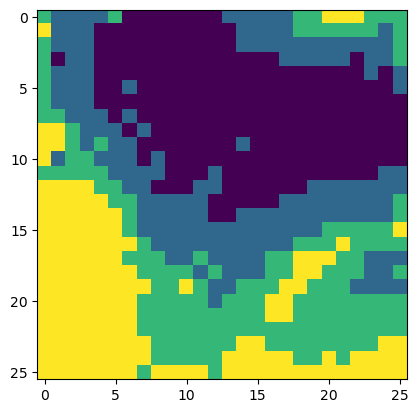

In [158]:
TomoBin4cell = np.empty(n_wide**2)
for i, mask in enumerate(cell_masks):
    TomoBin4cell[mask]=i+1
plt.imshow(TomoBin4cell.reshape(n_wide,n_wide))

In [159]:
p_z_c_hat_bins = [np.sum(p_z_c_hat[cell_masks[i]], axis=0) for i in range(4)]

print([np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * np.linspace(0, 2, nbins)[:-1]) for i in range(4)])

[0.33601758863679454, 0.5133245025019272, 0.7063495809542868, 0.870676824412592]


In [163]:
balrog

,Unnamed: 0.1,Unnamed: 0,ID,mcal_FLUX_i,mcal_FLUX_i_ERR,mcal_FLUX_r,mcal_FLUX_r_ERR,mcal_FLUX_z,mcal_FLUX_z_ERR,ra,...,true_FLUX_r,true_FLUX_z,true_dec,true_ra,wide_cells,detected,contmask,passes,p_pass,detected_float
0,0,0,692673826,3566.6780,72.019490,1540.9564,27.631138,5053.7324,83.642600,176.13657,...,1717.881100,6117.27930,-24.609833,176.136550,533,1,True,True,0.823529,1.0
1,19252,1320815,692673826,3477.6777,38.995434,1281.8691,32.220505,5408.4030,63.867596,180.83194,...,1717.881100,6117.27930,-7.921480,180.831950,581,1,True,True,0.823529,1.0
2,68138,1569941,692673826,NaN,NaN,NaN,NaN,NaN,NaN,177.20479,...,1717.881100,6117.27930,-2.632351,177.204790,0,1,True,False,0.823529,1.0
3,70487,1672410,692673826,NaN,NaN,NaN,NaN,NaN,NaN,197.87670,...,1717.881100,6117.27930,17.970901,197.876700,0,1,True,False,0.823529,1.0
4,74612,1876775,692673826,3873.8062,46.977474,1542.8325,27.505878,5663.5690,84.696365,157.87204,...,1717.881100,6117.27930,28.740143,157.872060,559,1,True,True,0.823529,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677876,98944,9009627,699800385,NaN,NaN,NaN,NaN,NaN,NaN,114.42572,...,456.615840,502.23285,27.135624,114.425690,0,1,True,False,0.000000,1.0
6677877,99053,9009736,692361158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,247.155350,390.22390,27.113167,114.419525,0,0,True,False,0.000000,0.0
6677878,99057,9009740,713129201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.330560,94.30596,27.138851,114.419480,0,0,True,False,0.000000,0.0
6677879,99088,9009771,698231519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.645863,109.79476,27.337683,114.418846,0,0,True,False,0.000000,0.0


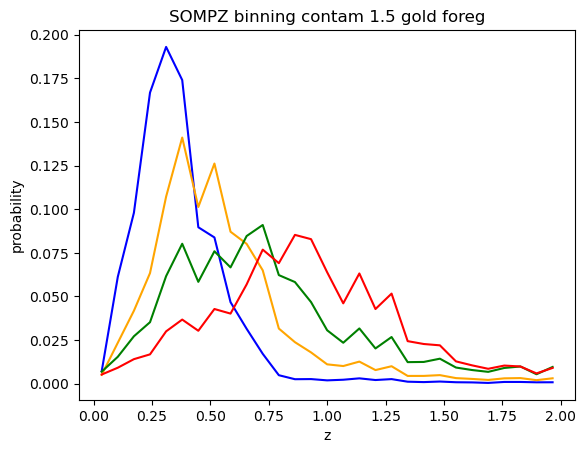

In [162]:
plt.figure()
plt.title('SOMPZ binning contam 1.5 gold foreg')
plt.xlabel('z')
plt.ylabel('probability')
colors = ['blue', 'orange', 'green', 'red']
plt.xticks(ticks=np.arange(0, 2.1, 0.25))
#plt.xlim(0,1.5)
for i in range(4):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i])
plt.show()

In [139]:
#np.savez('/project/chihway/raulteixeira/data/p_z_c_hat_bins_SOMPZ.npz', np.array(p_z_c_hat_bins))

In [140]:
#np.savetxt('/project/chihway/raulteixeira/data/p_z_c_hat_bins_SOMPZ.txt', np.array(p_z_c_hat_bins))

Text(0.5, 1.0, 'spec z/very good (many bands) photo-z')

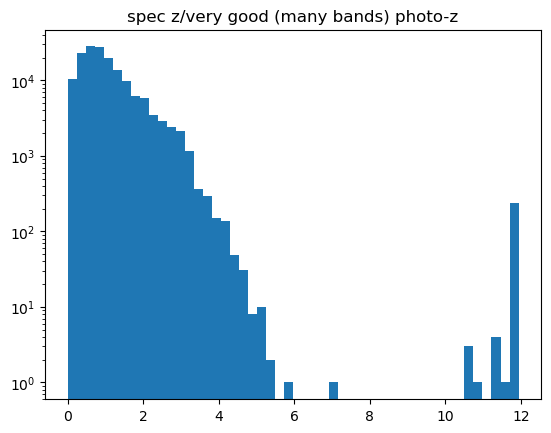

In [141]:
plt.hist(deep['Z'], bins=50)
plt.yscale('log')
plt.title('spec z/very good (many bands) photo-z')

Text(0.5, 1.0, 'spec z/very good (many bands) photo-z')

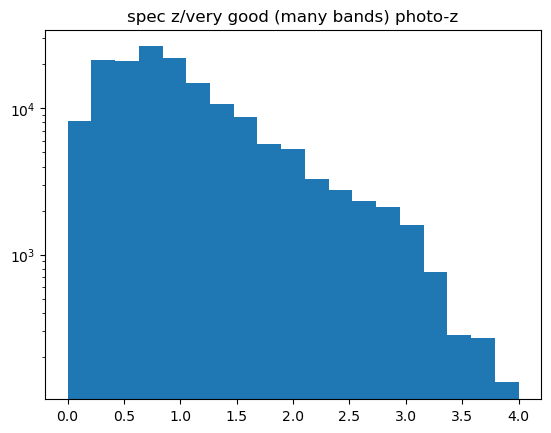

In [13]:
plt.hist(deep['Z'], bins=np.linspace(0, 4, 20))
plt.yscale('log')
plt.title('spec z/very good (many bands) photo-z')

### Deep2Wide plots (sanity checks!)

In [17]:
def group_i_deep(i, max_d, n):
    ps = np.array(np.unravel_index(np.arange(0,n**2), (n,n), order='F'))
    p = np.array(np.unravel_index(i, (n,n), order='F'))
    d = np.sum(np.abs(ps-p[:, None]),axis=0)
    return np.arange(0,n**2)[d<=max_d]

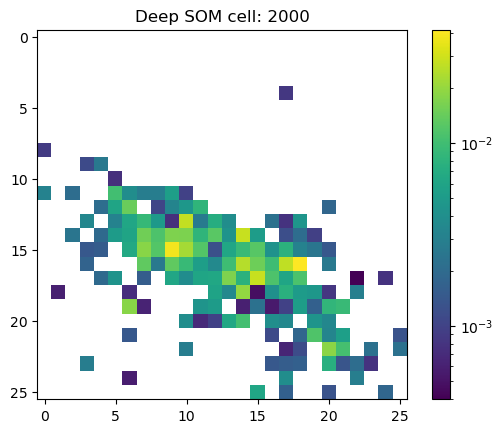

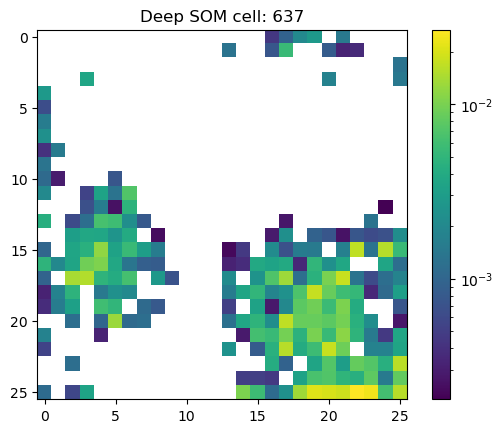

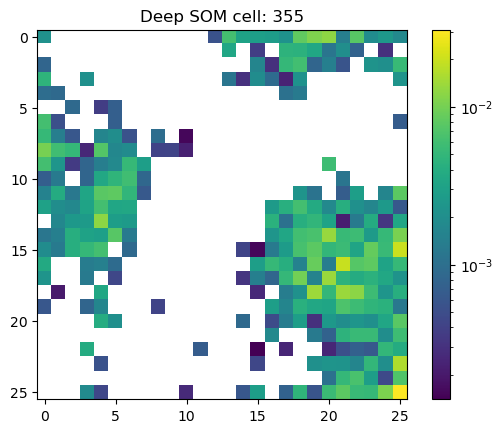

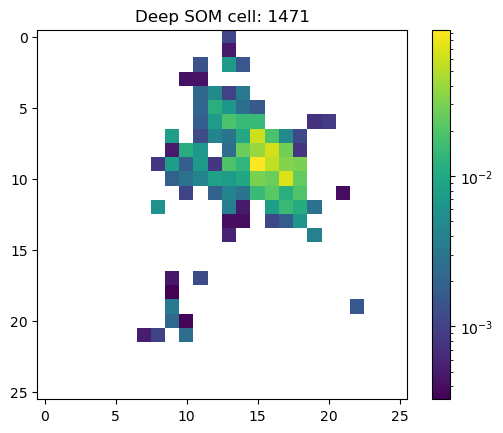

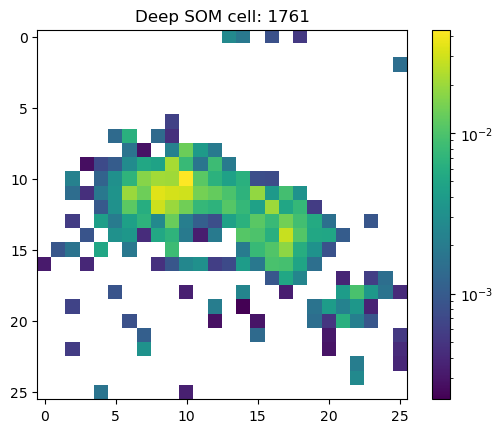

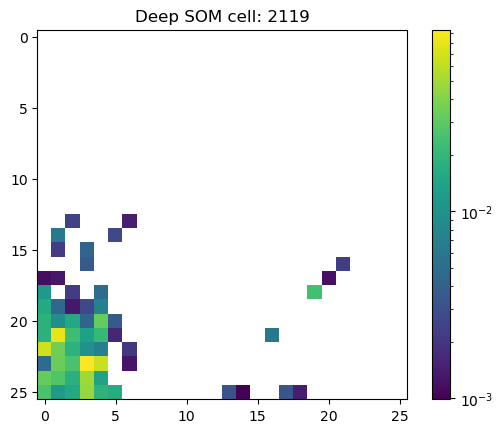

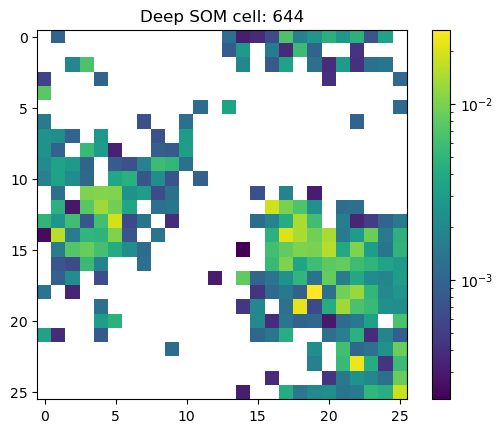

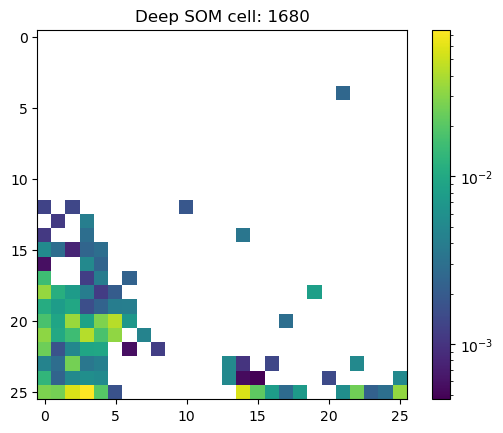

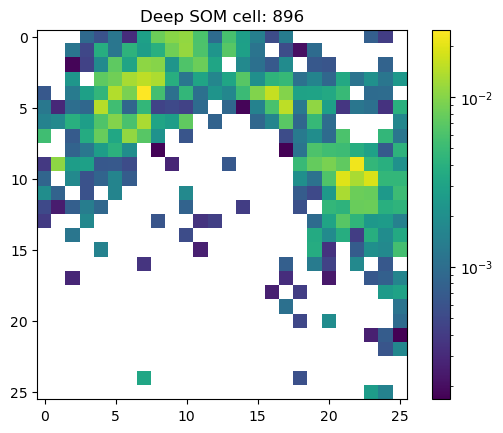

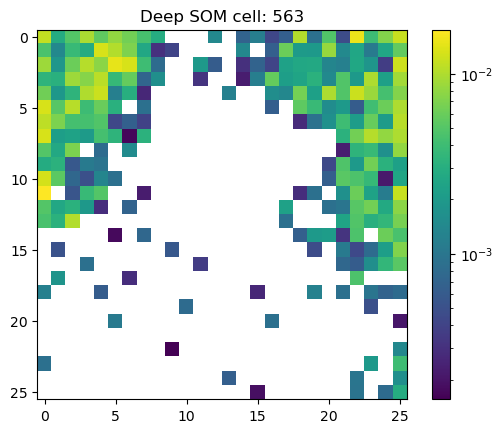

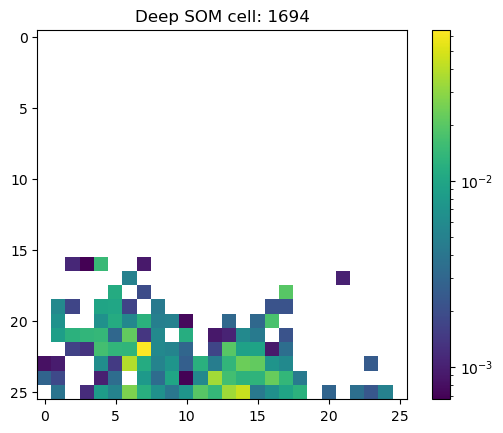

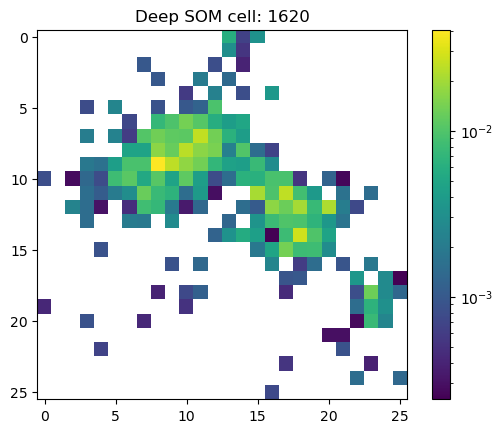

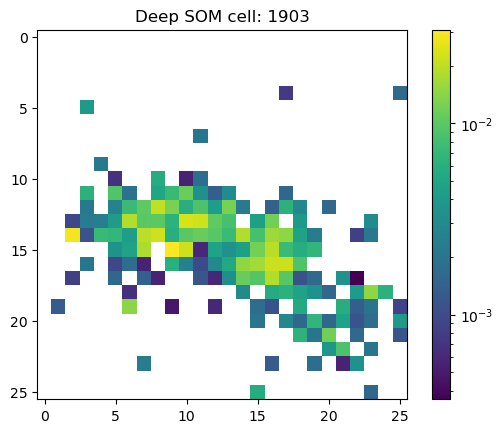

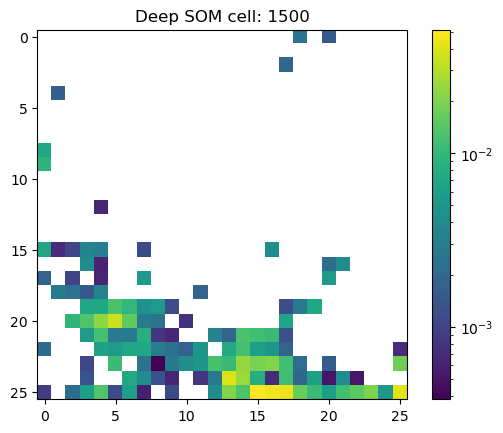

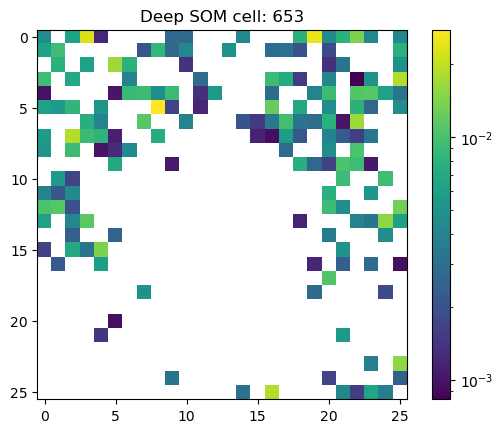

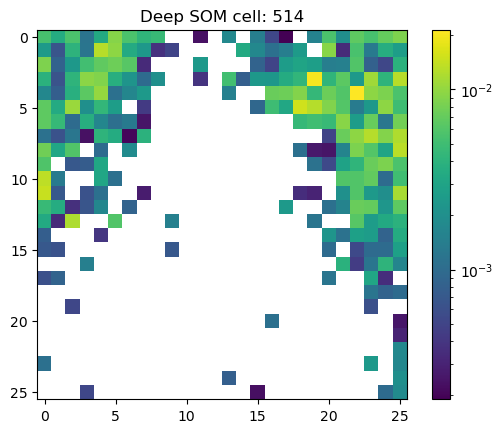

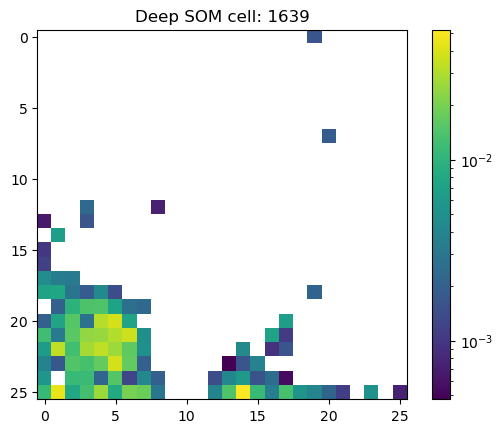

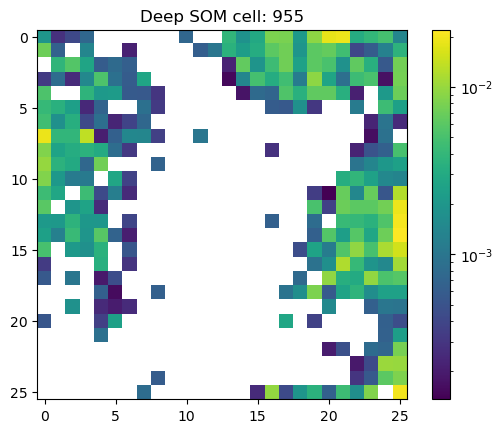

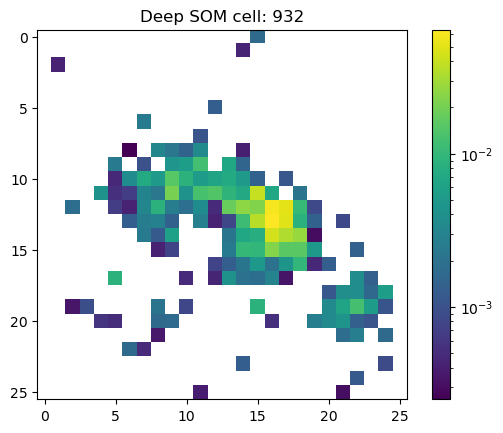

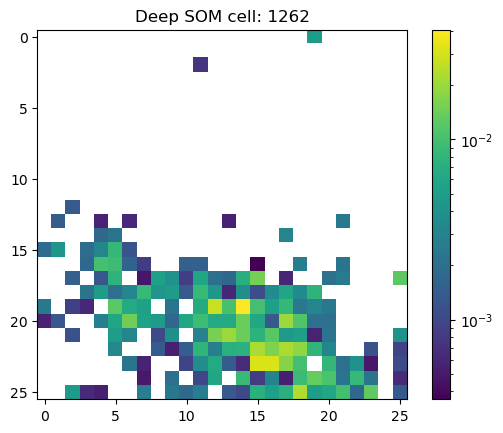

In [27]:
fig, axes = plt.subplots(nx, ny, figsize=(12, 24))
i_deeps = np.random.randint(0,n_deep**2, (nx, ny))
for i_deep in i_deeps:

    idx_deep = group_i_deep(i_deep, max_d=2, n=n_deep)

    plt.title(f'Deep SOM cell: {i_deep-1}')

    im = np.sum(p_cchat[:,idx_deep],axis=1).reshape(n_wide,n_wide)

    im /= np.sum(im)

    plt.title(f'Deep SOM cell: {i_deep-1}')
    plt.imshow(im, norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.show()